# GeoDatenErfassung25_HS_Mainz
Prof. Dr. Yu Feng

## 0. Erforderliche Bibliotheken installieren

**Hinweis:** Führen Sie die folgende Zelle aus, um alle benötigten Pakete zu installieren.

Falls Sie in Google Colab arbeiten, sind die meisten Pakete bereits installiert.

In [37]:
# Erforderliche Pakete installieren
# Entfernen Sie die Kommentare (#) vor den Zeilen, um die Pakete zu installieren

# !pip install stanza
# !pip install pandas
# !pip install folium
# !pip install seaborn
# !pip install ijson
# !pip install geopy

## 1. Bibliotheken importieren

In [59]:
import json
import ijson
import pandas as pd
import numpy as np
import stanza
import folium
from folium.plugins import MarkerCluster
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim

print("Bibliotheken erfolgreich importiert!")

Bibliotheken erfolgreich importiert!


## 2. JSON-Daten laden und Struktur analysieren

**Wichtig:** Bitte laden Sie zunächst die Daten herunter!

1. **Daten herunterladen**: Laden Sie die JSON-Datei von folgendem Link herunter:  
   https://seafile.rlp.net/f/7ff5a2d0f41948c28f5e/

2. **Daten speichern**: Legen Sie die heruntergeladene Datei `tweets_europe_west_2016_05_10.json` im Ordner `data/` ab (im gleichen Verzeichnis wie dieses Notebook).

3. **Für Google Colab**: Falls Sie in Colab arbeiten, laden Sie die Datei hoch oder mounten Sie Google Drive und passen Sie den Dateipfad in der nächsten Zelle entsprechend an.

In [39]:
# JSON-Datei laden (nur erste 500 Tweets)
# Für Google Colab: Pfad anpassen!
file_path = 'data/tweets_europe_west_2016_05_10.json'

tweets = []
with open(file_path, 'rb') as f:
    parser = ijson.items(f, 'item')
    for i, tweet in enumerate(parser):
        if i >= 500:
            break
        tweets.append(tweet)

print(f"Geladene Tweets: {len(tweets)}")

Geladene Tweets: 500


In [40]:
# Struktur des ersten Tweets untersuchen
if tweets:
    print("Struktur eines Tweets:")
    print(json.dumps(tweets[2], indent=2, ensure_ascii=False)[:1000])  # Erste 1000 Zeichen

Struktur eines Tweets:
{
  "_id": "573233b895f75e19d74ade50",
  "utc_offset": "-10800",
  "country_code": "ES",
  "text": "Se car el cielo en primavera #Madrid #puertadelsol @ Puerta del Sol Madrid https://t.co/lx4m50YnjD",
  "hashtags": "[{\"indices\":[29,36],\"text\":\"Madrid\"},{\"indices\":[37,50],\"text\":\"puertadelsol\"}]",
  "profile_image_url": "http://pbs.twimg.com/profile_images/727918483678371844/PdrAdb9E_normal.jpg",
  "bounding_box": {
    "type": "Polygon",
    "coordinates": "[[[-3.889005,40.312071],[-3.889005,40.643518],[-3.51801,40.643518],[-3.51801,40.312071]]]"
  },
  "coordinates": "[-3.70352705,40.41705918]",
  "full_name": "Madrid, España",
  "geo": {
    "type": "Point",
    "coordinates": "[40.41705918,-3.70352705]"
  },
  "id": "29709169",
  "name": "Madrid",
  "lang": "es",
  "screen_name": "laanabanana",
  "country": "España",
  "created_at": "Tue May 10 19:17:11 +0000 2016",
  "time_zone": "Santiago",
  "place_type": "city",
  "timestamp_ms": "1462907831787

In [41]:
# Wichtige Felder extrahieren
print("Verfügbare Hauptfelder:")
if tweets:
    for key in tweets[0].keys():
        print(f"  - {key}")

Verfügbare Hauptfelder:
  - _id
  - utc_offset
  - country_code
  - text
  - hashtags
  - profile_image_url
  - bounding_box
  - coordinates
  - full_name
  - geo
  - id
  - name
  - lang
  - screen_name
  - country
  - created_at
  - time_zone
  - place_type
  - timestamp_ms
  - source
  - followers_count
  - in_reply_to_screen_name
  - id_str
  - urls
  - location


## 3. Daten in DataFrame konvertieren

In [42]:
# Relevante Informationen extrahieren
data = []
for tweet in tweets:
    item = {
        'text': tweet.get('text', ''),
        'created_at': tweet.get('created_at', ''),
        'user_location': tweet.get('user', {}).get('location', ''),
        'coordinates': tweet.get('coordinates', None),
        'place': tweet.get('place', None),
        'lang': tweet.get('lang', '')
    }
    
    # Geo-Koordinaten extrahieren (vom Benutzer bereitgestellte Position)
    # Format: "[-4.46483776,36.72159228]" (JSON-Array als String)
    coords_str = tweet.get('coordinates', None)
    if coords_str:
        try:
            # String-Format parsen
            coords = json.loads(coords_str) if isinstance(coords_str, str) else coords_str
            if coords and isinstance(coords, list) and len(coords) == 2:
                item['longitude'] = coords[0]
                item['latitude'] = coords[1]
        except:
            pass
    
    # Place-Informationen extrahieren
    place_obj = tweet.get('place', None)
    if place_obj and isinstance(place_obj, dict):
        item['place_name'] = place_obj.get('full_name', '')
        item['country'] = place_obj.get('country', '')
    
    data.append(item)

df = pd.DataFrame(data)
print(f"DataFrame erstellt mit {len(df)} Eintraegen")
print(f"Tweets mit Standort-Koordinaten: {df['longitude'].notna().sum() if 'longitude' in df.columns else 0}")
df.head()

DataFrame erstellt mit 500 Eintraegen
Tweets mit Standort-Koordinaten: 500


,text,created_at,user_location,coordinates,place,lang,longitude,latitude
0,"Un toque de locura nunca viene mal, pues eso, ...",Tue May 10 19:17:11 +0000 2016,,"[-4.46483776,36.72159228]",None,es,-4.464838,36.721592
1,Motion de censure : Valls ne «craint» pas le r...,Tue May 10 19:17:11 +0000 2016,,"[2.2892648,48.8249147]",None,fr,2.289265,48.824915
2,Se car el cielo en primavera #Madrid #puertade...,Tue May 10 19:17:11 +0000 2016,,"[-3.70352705,40.41705918]",None,es,-3.703527,40.417059
3,@rhagallery @MickODeaArtist lovely to visit th...,Tue May 10 19:17:11 +0000 2016,,"[-6.24724667,53.33875333]",None,en,-6.247247,53.338753
4,"Desnudo como Adán el primer día @ Rome, Italy ...",Tue May 10 19:17:12 +0000 2016,,"[12.5,41.9]",None,es,12.500000,41.900000


In [43]:
# Statistiken anzeigen
print("\nDatensatz-Übersicht:")
if 'latitude' in df.columns and 'longitude' in df.columns:
    print(f"Tweets mit Standort-Koordinaten: {df['latitude'].notna().sum()}")
else:
    print(f"Tweets mit Standort-Koordinaten: 0")
print(f"Tweets mit Place-Info: {df['place_name'].notna().sum() if 'place_name' in df.columns else 0}")
print(f"Tweets mit User-Location: {df['user_location'].notna().sum()}")
print(f"\nSprachverteilung:")
print(df['lang'].value_counts())


Datensatz-Übersicht:
Tweets mit Standort-Koordinaten: 500
Tweets mit Place-Info: 0
Tweets mit User-Location: 500

Sprachverteilung:
lang
en     221
es      82
und     33
nl      29
de      22
ru      21
fr      21
it      19
pt       9
sv       9
pl       5
cs       4
fi       3
ar       2
tr       2
da       2
tl       2
is       2
lv       2
no       2
uk       2
eu       2
in       1
ro       1
lt       1
hu       1
Name: count, dtype: int64


In [44]:
# Koordinaten-Daten pruefen (optional - kann uebersprungen werden)
print("Koordinaten-Datenuebersicht:")
print(f"DataFrame Spalten: {df.columns.tolist()}")

if 'latitude' in df.columns:
    coords_count = (df['latitude'].notna() & df['longitude'].notna()).sum()
    print(f"\nTweets mit Koordinaten: {coords_count}")
    
    if coords_count > 0:
        coords_df = df[df['latitude'].notna() & df['longitude'].notna()]
        print(f"\nBeispiele:")
        print(coords_df[['text', 'latitude', 'longitude']].head(3))
else:
    print("\nKeine latitude/longitude Spalten gefunden")

Koordinaten-Datenuebersicht:
DataFrame Spalten: ['text', 'created_at', 'user_location', 'coordinates', 'place', 'lang', 'longitude', 'latitude']

Tweets mit Koordinaten: 500

Beispiele:
                                                text   latitude  longitude
0  Un toque de locura nunca viene mal, pues eso, ...  36.721592  -4.464838
1  Motion de censure : Valls ne «craint» pas le r...  48.824915   2.289265
2  Se car el cielo en primavera #Madrid #puertade...  40.417059  -3.703527


In [45]:
# Koordinaten-Extraktion verifizieren
print("=== Koordinaten-Verifikation ===")
print(f"DataFrame Zeilen: {len(df)}")

if 'latitude' in df.columns and 'longitude' in df.columns:
    coords_count = (df['latitude'].notna() & df['longitude'].notna()).sum()
    print(f"Tweets mit Standort-Koordinaten: {coords_count}")
    
    if coords_count > 0:
        print("\nBeispiele (erste 3):")
        sample_df = df[df['latitude'].notna()][['text', 'latitude', 'longitude']].head(3)
        for idx, row in sample_df.iterrows():
            print(f"  [{row['latitude']:.4f}, {row['longitude']:.4f}] - {row['text'][:50]}...")
else:
    print("Keine latitude/longitude Spalten gefunden")

=== Koordinaten-Verifikation ===
DataFrame Zeilen: 500
Tweets mit Standort-Koordinaten: 500

Beispiele (erste 3):
  [36.7216, -4.4648] - Un toque de locura nunca viene mal, pues eso, HAKU...
  [48.8249, 2.2893] - Motion de censure : Valls ne «craint» pas le renve...
  [40.4171, -3.7035] - Se car el cielo en primavera #Madrid #puertadelsol...


In [46]:
# Debug: coordinates Feld-Typ pruefen (optional)
print("Coordinates Feld-Analyse:")
print(f"Erstes coordinates: {df['coordinates'].iloc[0]}")
print(f"Typ: {type(df['coordinates'].iloc[0])}")
print(f"\nErste 5 coordinates:")
for i in range(min(5, len(df))):
    coord = df['coordinates'].iloc[i]
    print(f"  [{i}] {coord} - Typ: {type(coord)}")

Coordinates Feld-Analyse:
Erstes coordinates: [-4.46483776,36.72159228]
Typ: <class 'str'>

Erste 5 coordinates:
  [0] [-4.46483776,36.72159228] - Typ: <class 'str'>
  [1] [2.2892648,48.8249147] - Typ: <class 'str'>
  [2] [-3.70352705,40.41705918] - Typ: <class 'str'>
  [3] [-6.24724667,53.33875333] - Typ: <class 'str'>
  [4] [12.5,41.9] - Typ: <class 'str'>


## 4. Stanza für englische NER initialisieren

In [47]:
# Stanza englisches Modell herunterladen (nur beim ersten Mal nötig)
stanza.download('en')

2025-11-20 22:56:08 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:56:08 INFO: Downloading default packages for language: en (English) ...

2025-11-20 22:56:08 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:56:08 INFO: Downloading default packages for language: en (English) ...
2025-11-20 22:56:10 INFO: File exists: /Users/yufeng/stanza_resources/en/default.zip
2025-11-20 22:56:10 INFO: File exists: /Users/yufeng/stanza_resources/en/default.zip
2025-11-20 22:56:14 INFO: Finished downloading models and saved to /Users/yufeng/stanza_resources
2025-11-20 22:56:14 INFO: Finished downloading models and saved to /Users/yufeng/stanza_resources


In [48]:
# NER-Pipeline initialisieren
nlp = stanza.Pipeline('en', processors='tokenize,ner')
print("Stanza-Pipeline erfolgreich geladen!")

2025-11-20 22:56:14 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-11-20 22:56:14 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:56:14 WARNING: Language en package default expects mwt, which has been added
2025-11-20 22:56:14 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:56:14 WARNING: Language en package default expects mwt, which has been added
2025-11-20 22:56:15 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2025-11-20 22:56:15 INFO: Using device: cpu
2025-11-20 22:56:15 INFO: Loading: tokenize
2025-11-20 22:56:15 INFO: Loading these models f

Stanza-Pipeline erfolgreich geladen!


## 5. NER auf Tweets anwenden

In [49]:
# NER auf englische Tweets anwenden
def extract_entities(text):
    """Extrahiert Named Entities aus einem Text"""
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return []
    
    try:
        # Spezielle Zeichen entfernen (außer Buchstaben, Zahlen, Leerzeichen)
        import re
        text_cleaned = re.sub(r'[^\w\s]', ' ', text)
        
        doc = nlp(text_cleaned)
        entities = []
        for ent in doc.entities:
            entities.append({
                'text': ent.text,
                'type': ent.type
            })
        return entities
    except:
        return []

# Auf englische Tweets anwenden
english_tweets = df[df['lang'] == 'en'].copy()
print(f"Anzahl englischer Tweets: {len(english_tweets)}")

if len(english_tweets) > 0:
    print("\nNER wird angewendet (dies kann einige Zeit dauern)...")
    english_tweets['entities'] = english_tweets['text'].apply(extract_entities)
    print("NER-Extraktion abgeschlossen!")

Anzahl englischer Tweets: 221

NER wird angewendet (dies kann einige Zeit dauern)...
NER-Extraktion abgeschlossen!
NER-Extraktion abgeschlossen!


In [50]:
# Beispiele von extrahierten Entitaeten anzeigen
if len(english_tweets) > 0:
    print("Beispiele extrahierter Entitaeten:\n")
    for idx, row in english_tweets.head(5).iterrows():
        if row['entities']:
            print(f"Tweet: {row['text'][:80]}...")
            print(f"Entitaeten: {row['entities']}")
            print()

Beispiele extrahierter Entitaeten:

Tweet: #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | ...
Entitaeten: [{'text': 'UK', 'type': 'GPE'}, {'text': 'Ireland', 'type': 'GPE'}, {'text': 'Surrey', 'type': 'GPE'}]

Tweet: Just posted a photo @ Grosseto -Barbanella- https://t.co/ZH0KrRdlbv...
Entitaeten: [{'text': 'Grosseto  Barbanella', 'type': 'PERSON'}, {'text': 'ZH0KrRdlbv', 'type': 'PERSON'}]



## 6. Orte aus NER extrahieren und mit Geotags vergleichen

In [51]:
# LOC-Entitäten (Orte) extrahieren
def get_locations(entities):
    """Extrahiert Orts-Entitäten (LOC und GPE)
    LOC = Geographische Orte (Flüsse, Berge, etc.)
    GPE = Geopolitische Entitäten (Städte, Länder, etc.)
    """
    if not entities:
        return []
    return [ent['text'] for ent in entities if ent['type'] in ['LOC', 'GPE']]

if len(english_tweets) > 0:
    english_tweets['ner_locations'] = english_tweets['entities'].apply(get_locations)
    
    # Tweets mit NER-Orten
    tweets_with_ner_loc = english_tweets[english_tweets['ner_locations'].str.len() > 0]
    print(f"Tweets mit NER-erkannten Orten: {len(tweets_with_ner_loc)}")
    
    # Tweets mit Geotags
    if 'latitude' in english_tweets.columns and 'longitude' in english_tweets.columns:
        tweets_with_geotag = english_tweets[
            english_tweets['latitude'].notna() & english_tweets['longitude'].notna()
        ]
    else:
        tweets_with_geotag = pd.DataFrame()
    print(f"Tweets mit Geotags: {len(tweets_with_geotag)}")
    
    # Tweets mit beiden
    if len(tweets_with_geotag) > 0:
        tweets_both = english_tweets[
            (english_tweets['ner_locations'].str.len() > 0) & 
            (english_tweets['latitude'].notna())
        ]
    else:
        tweets_both = pd.DataFrame()
    print(f"Tweets mit NER-Orten UND Geotags: {len(tweets_both)}")

Tweets mit NER-erkannten Orten: 57
Tweets mit Geotags: 221
Tweets mit NER-Orten UND Geotags: 57


In [52]:
# 5 Beispiele von Tweets mit erkannten Orten anzeigen
if len(english_tweets) > 0:
    print("=== 5 BEISPIELE: TWEETS MIT NER-ERKANNTEN ORTEN ===\n")
    
    # Tweets mit erkannten Orten filtern
    tweets_with_locs = english_tweets[english_tweets['ner_locations'].str.len() > 0]
    
    if len(tweets_with_locs) > 0:
        for i, (idx, row) in enumerate(tweets_with_locs.head(5).iterrows(), 1):
            print(f"--- BEISPIEL {i} ---")
            print(f"Original-Text:")
            print(f"  {row['text'][:150]}...")
            print(f"\nErkannte Orte (LOC):")
            for loc in row['ner_locations']:
                print(f"  - {loc}")
            print(f"\nAlle Entitaeten:")
            for ent in row['entities']:
                print(f"  - {ent['text']} ({ent['type']})")
            print("\n")
    else:
        print("Keine Tweets mit erkannten Orten gefunden.")

=== 5 BEISPIELE: TWEETS MIT NER-ERKANNTEN ORTEN ===

--- BEISPIEL 1 ---
Original-Text:
  #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | #Sunbury, Surrey https://t.co/t7hiqRdpNN https://t.co/XyAmuKqFoQ...

Erkannte Orte (LOC):
  - UK
  - Ireland
  - Surrey

Alle Entitaeten:
  - UK (GPE)
  - Ireland (GPE)
  - Surrey (GPE)


--- BEISPIEL 2 ---
Original-Text:
  Cordoba: 9:18pm: sunset...

Erkannte Orte (LOC):
  - Cordoba

Alle Entitaeten:
  - Cordoba (GPE)
  - 18pm (TIME)


--- BEISPIEL 3 ---
Original-Text:
  Nec de lege Regia, printed at Paris, see Spondanus, (Annal. Ecclés. A.D. 1443, 1444) has been represented as a certain liquor named camus,...

Erkannte Orte (LOC):
  - Paris

Alle Entitaeten:
  - Nec de lege Regia (WORK_OF_ART)
  - Paris (GPE)


--- BEISPIEL 4 ---
Original-Text:
  Goteborg: 9:20pm: sunset...

Erkannte Orte (LOC):
  - Goteborg

Alle Entitaeten:
  - Goteborg (GPE)
  - 9 20pm (TIME)


--- BEISPIEL 5 ---
Original-Text:
  It's Darg Idol nig

In [ ]:
# Geocoding mit Nominatim (OpenStreetMap)
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# Geocoder initialisieren
geolocator = Nominatim(user_agent="twitter_ner_analysis")

def geocode_location(location_name, retry=3):
    """Versucht, Koordinaten für einen Ortsnamen zu finden"""
    if not location_name:
        return None, None
    
    for attempt in range(retry):
        try:
            time.sleep(1)  # Rate limiting
            location = geolocator.geocode(location_name, timeout=10)
            if location:
                return location.latitude, location.longitude
            return None, None
        except (GeocoderTimedOut, GeocoderServiceError):
            if attempt < retry - 1:
                time.sleep(2)
                continue
            return None, None
    return None, None

# NER-Orte geocodieren
if len(english_tweets) > 0 and len(tweets_with_ner_loc) > 0:
    print("Geocoding von NER-Orten (dies kann einige Zeit dauern)...\n")
    
    # Nur eindeutige Orte geocodieren
    unique_locations = set()
    for locs in english_tweets['ner_locations']:
        unique_locations.update(locs)
    
    location_coords = {}
    for i, loc in enumerate(unique_locations):
        if i >= 100:  # Limit erhöht für mehr Orte
            break
        lat, lon = geocode_location(loc)
        location_coords[loc] = (lat, lon)
        if lat:
            print(f"[OK] {loc}: ({lat:.4f}, {lon:.4f})")
        else:
            print(f"[--] {loc}: Nicht gefunden")
    
    print(f"\n{len([v for v in location_coords.values() if v[0]])} von {len(location_coords)} Orten erfolgreich geocodiert")

Geocoding von NER-Orten (dies kann einige Zeit dauern)...

[OK] Berlin: (52.5174, 13.3951)
[OK] Berlin: (52.5174, 13.3951)
[OK] Pamplona: (42.8182, -1.6440)
[OK] Pamplona: (42.8182, -1.6440)
[OK] Budapest: (47.4979, 19.0402)
[OK] Budapest: (47.4979, 19.0402)
[OK] Ellesmere: (79.6216, -76.7747)
[OK] Ellesmere: (79.6216, -76.7747)
[OK] Seville: (37.3886, -5.9953)
[OK] Seville: (37.3886, -5.9953)
[OK] Danube River: (47.9222, 17.4308)
[OK] Danube River: (47.9222, 17.4308)
[--] Halfway2_Heaven: Nicht gefunden
[--] Halfway2_Heaven: Nicht gefunden
[OK] Afghanistan: (33.7680, 66.2385)
[OK] Afghanistan: (33.7680, 66.2385)
[OK] Munich: (48.1371, 11.5754)
[OK] Munich: (48.1371, 11.5754)
[OK] Iceland: (64.9842, -18.1059)
[OK] Iceland: (64.9842, -18.1059)
[OK] Maldon  Essex: (51.7312, 0.6792)
[OK] Maldon  Essex: (51.7312, 0.6792)
[OK] Marquee: (-46.3668, 169.2681)
[OK] Marquee: (-46.3668, 169.2681)
[OK] UK: (54.7024, -3.2766)
[OK] UK: (54.7024, -3.2766)
[OK] London: (51.5074, -0.1278)
[OK] London: 

## 6.5 Geocoding: NER-Orte in Koordinaten umwandeln

In [54]:
# Vergleich: NER-Orte vs. Geotag-Orte
if len(english_tweets) > 0:
    print("\n=== VERGLEICH: NER-ORTE vs. GEOTAGS ===\n")
    
    for idx, row in english_tweets.head(10).iterrows():
        if row['ner_locations'] or row.get('place_name'):
            print(f"Tweet: {row['text'][:60]}...")
            print(f"  NER-Orte: {row['ner_locations']}")
            print(f"  Geotag-Ort: {row.get('place_name', 'N/A')}")
            if 'latitude' in row and pd.notna(row.get('latitude')):
                print(f"  Koordinaten: ({row.get('latitude')}, {row.get('longitude')})")
            print()


=== VERGLEICH: NER-ORTE vs. GEOTAGS ===

Tweet: #Sales alert: Residential Sales Consultant -... | IS&amp;S -...
  NER-Orte: ['UK', 'Ireland', 'Surrey']
  Geotag-Ort: N/A
  Koordinaten: (51.4191935, -0.4191503)

Tweet: Cordoba: 9:18pm: sunset...
  NER-Orte: ['Cordoba']
  Geotag-Ort: N/A
  Koordinaten: (37.88, -4.77)

Tweet: Nec de lege Regia, printed at Paris, see Spondanus, (Annal. ...
  NER-Orte: ['Paris']
  Geotag-Ort: N/A
  Koordinaten: (51.5, -0.13)



## 7. Sentiment-Analyse mit Stanza durchführen

In [55]:
# Sentiment-Analyse mit Stanza durchfuehren
# Stanza Pipeline mit Sentiment-Modell initialisieren
print("Stanza Sentiment-Pipeline wird geladen...")
sentiment_pipeline = stanza.Pipeline('en', processors='tokenize,sentiment')
print("Sentiment-Pipeline erfolgreich geladen!")

def analyze_sentiment(text):
    """Analysiert das Sentiment eines Textes mit Stanza
    
    Returns:
        str: 'positive', 'negative', or 'neutral'
    """
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return 'neutral'
    
    try:
        doc = sentiment_pipeline(text)
        # Stanza gibt Sentiment-Werte: 0=negative, 1=neutral, 2=positive
        sentiments = [sentence.sentiment for sentence in doc.sentences]
        
        if not sentiments:
            return 'neutral'
        
        # Durchschnittliches Sentiment berechnen
        avg_sentiment = sum(sentiments) / len(sentiments)
        
        # Klassifizierung
        if avg_sentiment < 0.8:
            return 'negative'
        elif avg_sentiment > 1.2:
            return 'positive'
        else:
            return 'neutral'
    except:
        return 'neutral'

# Sentiment-Analyse auf englische Tweets anwenden
if len(english_tweets) > 0:
    print("\nSentiment-Analyse wird durchgefuehrt (dies kann einige Zeit dauern)...")
    english_tweets['sentiment'] = english_tweets['text'].apply(analyze_sentiment)
    print("Sentiment-Analyse abgeschlossen!")
    
    print("\nSentiment-Verteilung:")
    print(english_tweets['sentiment'].value_counts())
    
    # Beispiele anzeigen
    print("\n=== BEISPIELE FUER VERSCHIEDENE SENTIMENTS ===\n")
    for sentiment_type in ['positive', 'negative', 'neutral']:
        examples = english_tweets[english_tweets['sentiment'] == sentiment_type].head(2)
        if len(examples) > 0:
            print(f"\n{sentiment_type.upper()}:")
            for idx, row in examples.iterrows():
                print(f"  - {row['text'][:100]}...")
            print()

2025-11-20 22:57:16 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Stanza Sentiment-Pipeline wird geladen...


2025-11-20 22:57:16 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:57:16 WARNING: Language en package default expects mwt, which has been added
2025-11-20 22:57:16 INFO: Downloaded file to /Users/yufeng/stanza_resources/resources.json
2025-11-20 22:57:16 WARNING: Language en package default expects mwt, which has been added
2025-11-20 22:57:17 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2025-11-20 22:57:17 INFO: Using device: cpu
2025-11-20 22:57:17 INFO: Loading: tokenize
2025-11-20 22:57:17 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2025-11-20 22:57:17 INFO: Using device: cpu
2025-11-20 22:57:17 INFO: Loading: tokeniz

Sentiment-Pipeline erfolgreich geladen!

Sentiment-Analyse wird durchgefuehrt (dies kann einige Zeit dauern)...
Sentiment-Analyse abgeschlossen!

Sentiment-Verteilung:
sentiment
neutral     153
positive     45
negative     23
Name: count, dtype: int64

=== BEISPIELE FUER VERSCHIEDENE SENTIMENTS ===


POSITIVE:
  - @rhagallery @MickODeaArtist lovely to visit thanks for coming https://t.co/jKu0u8tmv3...
  - Regram 📸 @LifestyleLauren - wining and dining at the humblegrapewine #fleetstreet launch!… https://t...


NEGATIVE:
  - @AbiolaAbdul Exactly. Look at the Western-owned oil companies currently draining our resources and n...
  - @realdealdanny it's probably nothing but it is as you said. Bad fucking timing. Now we're going to h...


NEUTRAL:
  - #Sales alert: Residential Sales Consultant -... | IS&amp;S - UK &amp; Ireland | #Sunbury, Surrey htt...
  - Trend Alert: 'Upton Park'. More trends at https://t.co/GW5DvL3F8y #trndnl https://t.co/dV7YWK00is...

Sentiment-Analyse abgeschlossen!



## 8. Häufigste Orte und Entitäten analysieren

Top 10 häufigste NER-extrahierte Orte:
  Ireland: 4
  London: 3
  Paris: 2
  Barcelona City: 2
  Sevilla: 2
  Essex: 2
  West Ham: 2
  Manchester: 2
  Ibiza: 2
  UK: 1


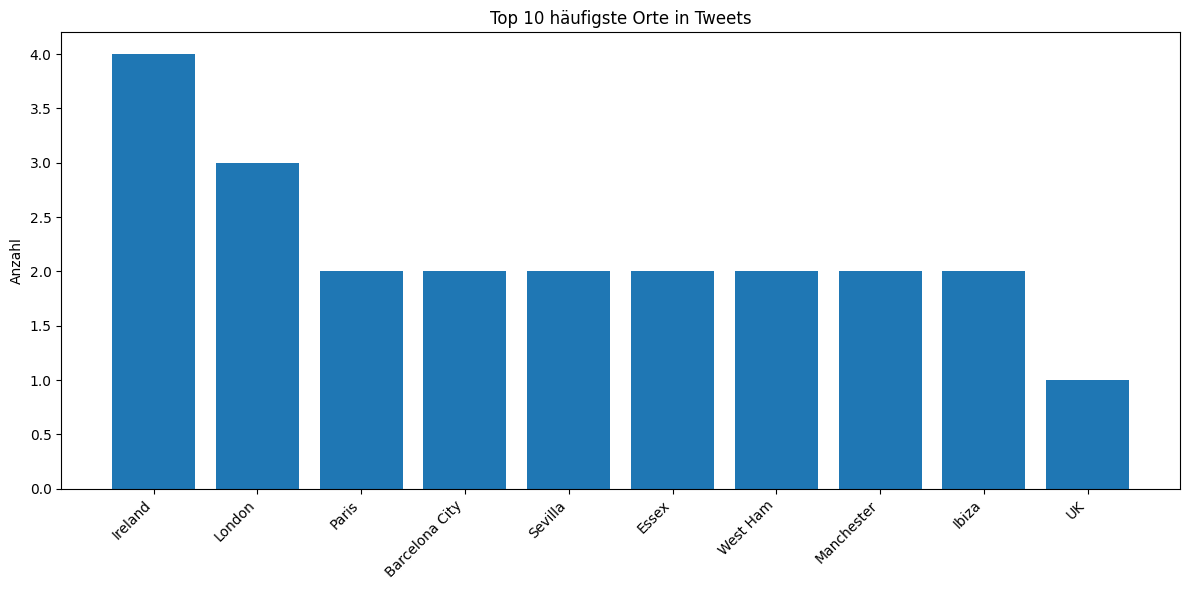

In [56]:
# Top NER-Orte
if len(english_tweets) > 0:
    all_locations = []
    for locs in english_tweets['ner_locations']:
        all_locations.extend(locs)
    
    if all_locations:
        loc_counter = Counter(all_locations)
        print("Top 10 häufigste NER-extrahierte Orte:")
        for loc, count in loc_counter.most_common(10):
            print(f"  {loc}: {count}")
        
        # Visualisierung
        top_locs = dict(loc_counter.most_common(10))
        plt.figure(figsize=(12, 6))
        plt.bar(top_locs.keys(), top_locs.values())
        plt.xticks(rotation=45, ha='right')
        plt.title('Top 10 häufigste Orte in Tweets')
        plt.ylabel('Anzahl')
        plt.tight_layout()
        plt.show()

## 9. Folium-Karte erstellen mit farbcodierten Kategorien

In [65]:
# Farbschema fuer Sentiments
category_colors = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

if len(english_tweets) > 0:
    # Karte zentrieren (Mitteleuropa)
    center_lat = 50.0
    center_lon = 10.0
    
    # Folium-Karte erstellen
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=4,
        tiles='OpenStreetMap'
    )
    
    # Zwei separate Layer-Gruppen mit Clustering erstellen
    # maxClusterRadius=0 bedeutet: nur exakt gleiche Koordinaten werden geclustert
    geotag_layer = MarkerCluster(
        name='Geotag-Positionen (Tweet-Standorte)', 
        show=True,
        options={'maxClusterRadius': 0.1}
    )
    ner_layer = MarkerCluster(
        name='NER-Orte (Text-Erwaehnung)', 
        show=True,
        options={'maxClusterRadius': 0.1}
    )
    
    # 1. GEOTAG-MARKER und NER-MARKER zusammen erstellen (mit gleicher Nummerierung)
    if 'latitude' in english_tweets.columns and 'longitude' in english_tweets.columns:
        tweets_with_coords = english_tweets[
            (english_tweets['latitude'].notna() & english_tweets['longitude'].notna()) &
            (english_tweets['ner_locations'].str.len() > 0)
        ].copy()
    else:
        tweets_with_coords = pd.DataFrame()
        print("Keine latitude/longitude Spalten gefunden")
    
    print(f"Gefunden: {len(tweets_with_coords)} Tweets mit NER-Orten (zeige Geotags)...")
    
    if len(tweets_with_coords) > 0:
        geotag_added = 0
        ner_added = 0
        
        for tweet_number, (idx, row) in enumerate(tweets_with_coords.iterrows(), 1):
            # Geotag-Marker hinzufuegen
            lat = row.get('latitude')
            lon = row.get('longitude')
            
            if pd.notna(lat) and pd.notna(lon):
                color = category_colors.get(row['sentiment'], 'gray')
                ner_locs = ', '.join(row['ner_locations']) if row['ner_locations'] else 'N/A'
                
                # Popup fuer Geotag
                popup_text = f"""
                GEOTAG #{tweet_number}
                Sentiment: {row['sentiment']}
                NER-Orte: {ner_locs}
                Text: {row['text'][:100]}...
                Koordinaten: ({lat:.4f}, {lon:.4f})
                """
                
                # Geotag-Marker mit Nummer als DivIcon
                folium.Marker(
                    location=[lat, lon],
                    popup=folium.Popup(popup_text, max_width=300),
                    icon=folium.DivIcon(html=f'''
                        <div style="
                            width: 30px;
                            height: 30px;
                            border-radius: 50%;
                            background-color: {color};
                            border: 2px solid white;
                            display: flex;
                            align-items: center;
                            justify-content: center;
                            font-weight: bold;
                            font-size: 14px;
                            color: white;
                            text-shadow: 1px 1px 2px rgba(0,0,0,0.8);
                        ">{tweet_number}</div>
                    '''),
                    tooltip=f"#{tweet_number} - {row['sentiment']}"
                ).add_to(geotag_layer)
                geotag_added += 1
                
                # Fuer jeden NER-Ort in diesem Tweet einen Marker hinzufuegen
                for ner_location in row['ner_locations']:
                    if ner_location in location_coords:
                        ner_lat, ner_lon = location_coords[ner_location]
                        if ner_lat and ner_lon:
                            popup_text = f"""
                            NER-ORT #{tweet_number}
                            Ort: {ner_location}
                            Koordinaten: ({ner_lat:.4f}, {ner_lon:.4f})
                            Tweet: {row['text'][:80]}...
                            """
                            
                            # NER-Marker mit Nummer als Marker-Pin
                            folium.Marker(
                                location=[ner_lat, ner_lon],
                                popup=folium.Popup(popup_text, max_width=300),
                                icon=folium.DivIcon(html=f'''
                                    <div style="position: relative; text-align: center;">
                                        <div style="
                                            width: 0;
                                            height: 0;
                                            border-left: 15px solid transparent;
                                            border-right: 15px solid transparent;
                                            border-top: 30px solid orange;
                                            position: relative;
                                        "></div>
                                        <div style="
                                            position: absolute;
                                            top: 5px;
                                            left: 50%;
                                            transform: translateX(-50%);
                                            font-weight: bold;
                                            font-size: 14px;
                                            color: white;
                                            text-shadow: 1px 1px 2px rgba(0,0,0,0.8);
                                        ">{tweet_number}</div>
                                    </div>
                                '''),
                                tooltip=f"#{tweet_number} - {ner_location}"
                            ).add_to(ner_layer)
                            ner_added += 1
        
        print(f"Geotag-Marker hinzugefuegt: {geotag_added}")
        print(f"Geotag-Marker hinzugefuegt: {geotag_added}")
        print(f"NER-Marker hinzugefuegt: {ner_added}")
    else:
        print("Keine Geotags gefunden")
        print("   Grund: Wenige Tweets haben Standort-Koordinaten vom Benutzer")
    
    # Layer zu Karte hinzufuegen
    geotag_layer.add_to(m)
    ner_layer.add_to(m)
    
    # Layer-Control hinzufuegen
    folium.LayerControl(position='topright', collapsed=False).add_to(m)
    
    # Einfache Legende hinzufuegen
    legend_html = '''
    <div style="position:fixed; bottom:50px; right:50px; width:180px; 
                background-color:white; border:2px solid grey; z-index:9999; 
                padding:10px; font-size:12px;">
    <p style="margin:0 0 8px 0; font-weight:bold;">LEGENDE</p>
    <p style="margin:5px 0;"><span style="color:green;">●</span> Positiv</p>
    <p style="margin:5px 0;"><span style="color:red;">●</span> Negativ</p>
    <p style="margin:5px 0;"><span style="color:gray;">●</span> Neutral</p>
    <p style="margin:8px 0 5px 0; font-weight:bold;">MARKER</p>
    <p style="margin:5px 0;">● Kreis: Geotag</p>
    <p style="margin:5px 0;">▼ Dreieck: NER-Ort</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Statistiken
    geotag_count = len(tweets_with_coords) if 'tweets_with_coords' in locals() and len(tweets_with_coords) > 0 else 0
    ner_count = len([v for v in location_coords.values() if v[0]]) if 'location_coords' in dir() else 0
    
    print(f"\n=== Karte erstellt ===")
    print(f"Geotag-Layer: {geotag_count} Marker (Farben: gruen=positiv, rot=negativ, grau=neutral)")
    print(f"NER-Layer: {ner_count} Marker (orange Icons)")
    print(f"Gesamt: {geotag_count + ner_count} Marker")
    
    if geotag_count == 0:
        print(f"\nHinweis: Keine Geotag-Daten in ersten 500 Tweets!")
        print(f"Grund: Nur wenige Twitter-Nutzer teilen ihre Standort-Koordinaten")
    
    print(f"\nNutzen Sie den Layer-Control (rechts oben) zum Ein-/Ausschalten der Layer!")
    
    # Speichern und anzeigen
    m.save('twitter_map_comparison.html')
    print(f"\nKarte gespeichert: twitter_map_comparison.html")
    
    m
else:
    print("Keine englischen Tweets gefunden!")

Gefunden: 57 Tweets mit NER-Orten (zeige Geotags)...
Geotag-Marker hinzugefuegt: 57
Geotag-Marker hinzugefuegt: 57
NER-Marker hinzugefuegt: 22

=== Karte erstellt ===
Geotag-Layer: 57 Marker (Farben: gruen=positiv, rot=negativ, grau=neutral)
NER-Layer: 19 Marker (orange Icons)
Gesamt: 76 Marker

Nutzen Sie den Layer-Control (rechts oben) zum Ein-/Ausschalten der Layer!

Karte gespeichert: twitter_map_comparison.html


## 10. Zusammenfassung und Erkenntnisse

In [58]:
if len(english_tweets) > 0:
    print("=== ZUSAMMENFASSUNG DER ANALYSE ===")
    print(f"\nGesamt analysierte englische Tweets: {len(english_tweets)}")
    print(f"Tweets mit NER-Entitäten: {english_tweets['entities'].apply(len).sum()}")
    
    # Latitude-Spalte pruefen
    if 'latitude' in english_tweets.columns:
        print(f"Tweets mit Geolokalisierung: {english_tweets['latitude'].notna().sum()}")
    else:
        print(f"Tweets mit Geolokalisierung: 0")
    
    print(f"\nUnterschied NER vs. Geotags:")
    print(f"  - NER erkennt Orte im TEXT der Tweets")
    print(f"  - Geotags zeigen den STANDORT des Autors")
    print(f"  - Diese stimmen oft NICHT überein!")
    
    if 'sentiment' in english_tweets.columns:
        print(f"\nSentiment-Verteilung:")
        print(english_tweets['sentiment'].value_counts().to_string())

=== ZUSAMMENFASSUNG DER ANALYSE ===

Gesamt analysierte englische Tweets: 221
Tweets mit NER-Entitäten: 285
Tweets mit Geolokalisierung: 221

Unterschied NER vs. Geotags:
  - NER erkennt Orte im TEXT der Tweets
  - Geotags zeigen den STANDORT des Autors
  - Diese stimmen oft NICHT überein!

Sentiment-Verteilung:
sentiment
neutral     153
positive     45
negative     23
